In this notebook, our goal is to predict whether the Math students at a Portuguese school will pass. The dataset is publicly available at https://archive.ics.uci.edu/dataset/320/student+performance, where it is covered in more detail.

In [1]:
# Bread and Butter Libraries
import numpy as np
import pandas as pd

# Utilities
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import RocCurveDisplay
from datetime import datetime


# Models
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier as RF, GradientBoostingClassifier as GB)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

## Exploration Phase

In [2]:
math_data = pd.read_csv('student-mat.csv', delimiter= ';')
math_data

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,...,5,5,4,4,5,4,11,9,9,9
391,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,3,14,16,16
392,MS,M,21,R,GT3,T,1,1,other,other,...,5,5,3,3,3,3,3,10,8,7
393,MS,M,18,R,LE3,T,3,2,services,other,...,4,4,1,3,4,5,0,11,12,10


In [3]:
# Drop the other response variables in the dataset, G3 (final score) is our focus
math_data = math_data.drop(columns=['G1','G2'], axis=1)
math_data

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,4,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,10,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,2,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,no,4,3,2,1,2,5,4,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,...,no,no,5,5,4,4,5,4,11,9
391,MS,M,17,U,LE3,T,3,1,services,services,...,yes,no,2,4,5,3,4,2,3,16
392,MS,M,21,R,GT3,T,1,1,other,other,...,no,no,5,5,3,3,3,3,3,7
393,MS,M,18,R,LE3,T,3,2,services,other,...,yes,no,4,4,1,3,4,5,0,10


In [4]:
# Check Dtypes
math_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

In [5]:
# Dummy Encode Categorical variables
df =pd.get_dummies(math_data, prefix=['school','sex','address','famsize','Pstatus','Mjob','Fjob','reason','guardian','schoolsup','famsup','paid','activities','nursery','higher','internet','romantic'])
df["pass"] = df['G3'].values > 10
df.replace({False: 0, True: 1}, inplace=True)
df

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes,pass
0,18,4,4,2,2,0,4,3,4,1,...,0,0,1,0,1,1,0,1,0,0
1,17,1,1,1,2,0,5,3,3,1,...,0,1,0,0,1,0,1,1,0,0
2,15,1,1,1,2,3,4,3,2,2,...,0,0,1,0,1,0,1,1,0,0
3,15,4,2,1,3,0,3,2,2,1,...,1,0,1,0,1,0,1,0,1,1
4,16,3,3,1,2,0,4,3,2,1,...,0,0,1,0,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,20,2,2,1,2,2,5,5,4,4,...,0,0,1,0,1,1,0,1,0,0
391,17,3,1,2,1,0,2,4,5,3,...,0,1,0,0,1,0,1,1,0,1
392,21,1,1,1,1,3,5,5,3,3,...,0,1,0,0,1,1,0,1,0,0
393,18,3,2,3,1,0,4,4,1,3,...,0,1,0,0,1,0,1,1,0,0


In [6]:
# Ensure Correct Datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 58 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   age                395 non-null    int64
 1   Medu               395 non-null    int64
 2   Fedu               395 non-null    int64
 3   traveltime         395 non-null    int64
 4   studytime          395 non-null    int64
 5   failures           395 non-null    int64
 6   famrel             395 non-null    int64
 7   freetime           395 non-null    int64
 8   goout              395 non-null    int64
 9   Dalc               395 non-null    int64
 10  Walc               395 non-null    int64
 11  health             395 non-null    int64
 12  absences           395 non-null    int64
 13  G3                 395 non-null    int64
 14  school_GP          395 non-null    int64
 15  school_MS          395 non-null    int64
 16  sex_F              395 non-null    int64
 17  sex_M           

In [7]:
# Drop other response columns - see original dateset source for more details

X_col = df[df.columns.drop(['G3','pass'])]
Y_col = df[['pass']]

In [8]:
# Split the data

X_train, X_test, Y_train, Y_test = train_test_split(X_col,Y_col, test_size= 0.25, random_state= 22)

## Modeling Phase

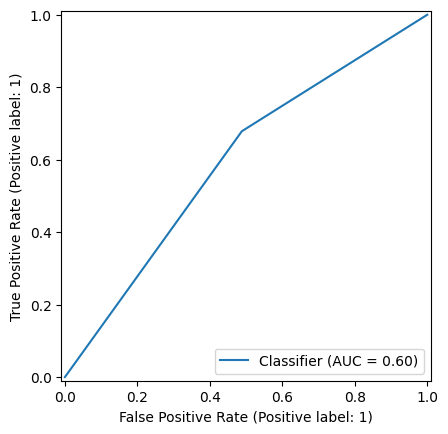

In [9]:
# Decision Tree

Cs = 10. ** np.arange(-3, 4)
tree_params = {'random_state': [22], 'ccp_alpha' : Cs.tolist()}
Dtree = GridSearchCV(DecisionTreeClassifier(), param_grid= tree_params)
Dtree.fit(X_train,Y_train)
preds = Dtree.predict(X_test)
RocCurveDisplay.from_predictions(Y_test,preds)

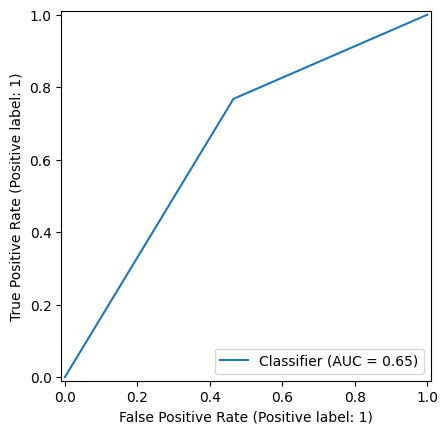

In [26]:
#Linear Discriminant Analysis

LD = LDA()
LD.fit(X_train,Y_train.values.ravel())
preds = LD.predict(X_test)
RocCurveDisplay.from_predictions(Y_test,preds)

C:\Users\Navid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\discriminant_analysis.py:949: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


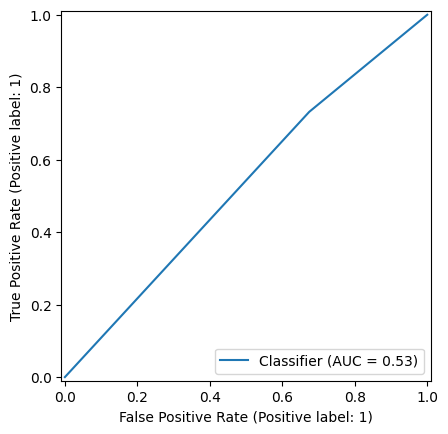

In [25]:
#Quadratic Discriminant Analysis

QD = QDA()
QD.fit(X_train,Y_train.values.ravel())
preds = QD.predict(X_test)
RocCurveDisplay.from_predictions(Y_test,preds)

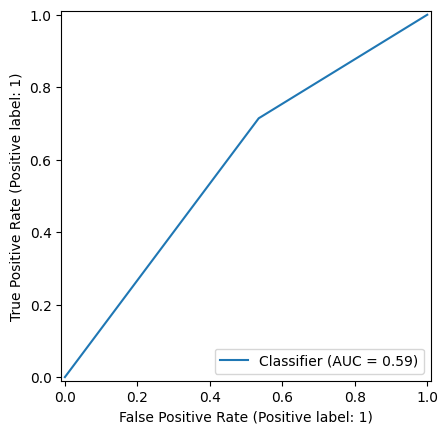

In [24]:
# Scale Variables for Regularization

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(X_train)

x_test_scaled = scaler.fit_transform(X_test)


param_grid = {"penalty": ["l1","l2"], "C": Cs, 'solver': ['liblinear']}

# Logistic Regression

Logreg = GridSearchCV(LogisticRegression(),param_grid= param_grid)
Logreg.fit(x_train_scaled,Y_train.values.ravel())
preds = Logreg.predict(x_test_scaled)
RocCurveDisplay.from_predictions(Y_test,preds)

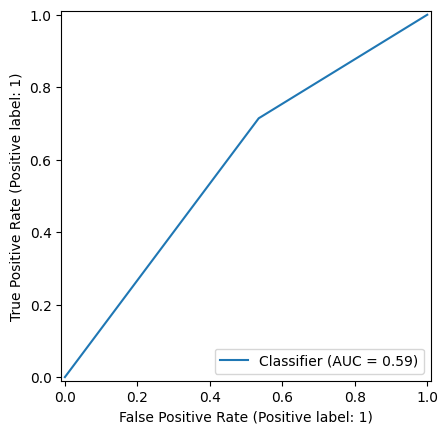

In [20]:
# Naive Bayes

NB = GaussianNB()
NB.fit(X_train,Y_train.values.ravel())
preds = NB.predict(X_test)
RocCurveDisplay.from_predictions(Y_test,preds)

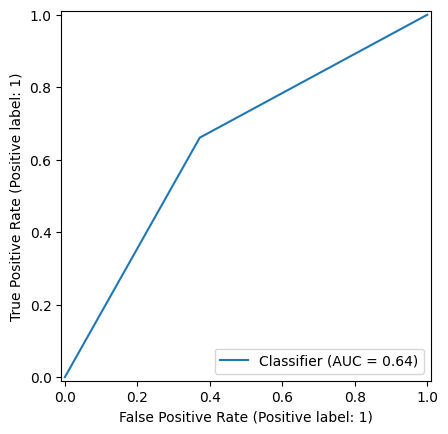

In [18]:
# Support Vector Machine (Radial Basis Function Kernel)

gammas = 10. ** np.arange(-3, 3)


rbf_grid = {'C':Cs, 'gamma':gammas, 'kernel':['rbf']}


SVMachine = GridSearchCV(SVC(),param_grid= rbf_grid)

SVMachine.fit(x_train_scaled,Y_train.values.ravel())

preds = SVMachine.predict(x_test_scaled)

RocCurveDisplay.from_predictions(Y_test,preds)

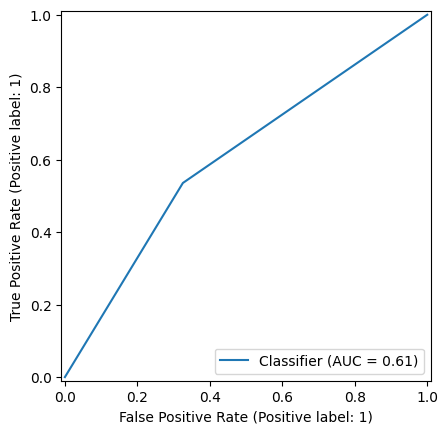

In [19]:
# Nearest Neighbors Classifier

Neighbor_param_grid = {"n_neighbors": [1,2,3,5,10,20,50,75,100]}

KN = GridSearchCV(KNeighborsClassifier(),param_grid= Neighbor_param_grid)

KN.fit(x_train_scaled,Y_train.values.ravel())

preds = KN.predict(x_test_scaled)

RocCurveDisplay.from_predictions(Y_test,preds)

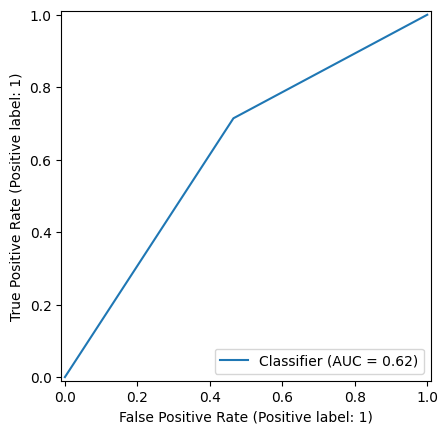

In [29]:
# Gradient Boosting

GB_param_grid = {'learning_rate': [0.1,0.01,0.001], 'n_estimators': [100, 500, 1000], 'max_depth': [3], 'random_state': [22]} 

Boost = GridSearchCV(GB(), param_grid= GB_param_grid)

Boost.fit(X_train,Y_train.values.ravel())

preds = Boost.predict(X_test)

RocCurveDisplay.from_predictions(Y_test,preds)

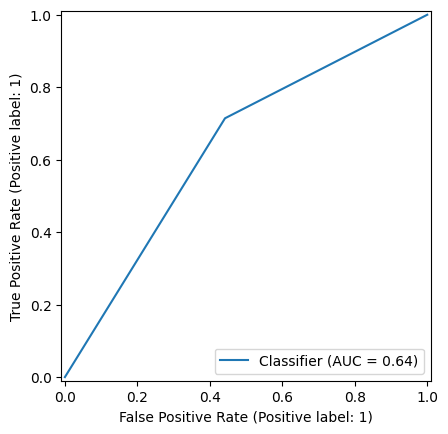

In [33]:
# Random Forest

RF_param_grid = {'n_estimators': [200,500], 'max_features': [2,3,4,5,10,15,20,25,30,35,40,45,50,56], 'random_state': [22]} 

RandF = GridSearchCV(RF(),param_grid= RF_param_grid)

RandF.fit(X_train,Y_train.values.ravel())

preds = RandF.predict(X_test)

RocCurveDisplay.from_predictions(Y_test,preds)